<a href="https://colab.research.google.com/github/RoelRotti/ADStructures/blob/master/Kopie_van_DMT_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Techniques Group 66 Assignment 2


In [ ]:
!pip install kaggle --upgrade
!pip install xgboost

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [ ]:
# All imports together
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from google.colab import drive
import gc
from xgboost import XGBRegressor
from matplotlib import pyplot
import pickle

# Ensemble:
from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

RANDOM_STATE = 42

In [ ]:
# Create folder in drive where datasets can be stored, in this folder you 
# need to store the JSON file with the Kaggle API key (Account-> 'Create new API token')
RUN = True
if RUN:
    drive.mount('/content/gdrive')

    os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

    %cd /content/gdrive/My Drive/Kaggle

    # load datasets into folder named "Kaggle"
    !kaggle competitions download -c 2nd-assignment-dmt-2021

    !unzip \*.zip  && rm *.zip

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle
 95% 125M/132M [00:01<00:00, 106MB/s]
100% 132M/132M [00:01<00:00, 108MB/s]
 90% 109M/121M [00:01<00:00, 20.7MB/s] 
100% 121M/121M [00:01<00:00, 83.3MB/s]
 88% 17.0M/19.4M [00:00<00:00, 36.0MB/s]
100% 19.4M/19.4M [00:00<00:00, 49.0MB/s]
Archive:  training_set_VU_DM.csv.zip
replace training_set_VU_DM.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  test_set_VU_DM.csv.zip
replace test_set_VU_DM.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

Archive:  submission_sample.csv.zip
replace submission_sample.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n

3 archives were successfully processed.


In [ ]:
# Loading the data into a pandas dataframe
df_train = pd.read_csv("training_set_VU_DM.csv", parse_dates=["date_time"])
df_test = pd.read_csv("test_set_VU_DM.csv", parse_dates=["date_time"])

In [ ]:
# scoring function
def dcg_at_k(sorted_labels, k = 5):
  if k > 0:
    k = min(sorted_labels.shape[0], k)
  else:
    k = sorted_labels.shape[0]
  denom = 1./np.log2(np.arange(k)+2.)
  nom = 2**sorted_labels-1.
  dcg = np.sum(nom[:k]*denom)
  return dcg

def ndcg_at_k(sorted_labels, ideal_labels, k = 5):
  return dcg_at_k(sorted_labels, k) / dcg_at_k(ideal_labels, k)

In [ ]:
# relevance label function
def label_relevance(row):
  if row.booking_bool == 1:
    return 5
  elif row.click_bool == 1:
    return 1
  else:
    return 0

## Business Understanding (Literature Research)


*Your task is to predict what hotels properties listed as a result of a hotel search a user is most
likely to click on. Of course, more people have worked on such predictions. Can you find
some other people that have tried to make such predictions (e.g. from the Kaggle competition)? And what have they used as most prominent predictors? Have other people that
participate in the competition mentioned anything about their approaches? Please spend a
couple of paragraphs on this topic (i.e. related work) in your report.*


Links to other codes and explanations of this project.
https://www.kaggle.com/c/expedia-hotel-recommendations/code

Options:
- Feature importance again can be checked with correlation and the importance scores in the Random Forest as we've done in the previous assignment. Some other options are given (for example specifically for XGBoost) in this tutorial for python (**!!!!!!!!! THIS LINK IS REALLY NICE FOR FEATURE IMPORTANCE EXTRACTION https://machinelearningmastery.com/calculate-feature-importance-with-python/ !!!!!!!!**)
- K-nearest Neighbour & Aglomerative Clustering (https://www.kaggle.com/xseungyeonleex/expedia-hotel-recommendations-practice)
- Random Forest (https://www.kaggle.com/noddabodder/random-forest)
- Paper compares RF : Random Forest, SGD : Stochastic Gradient
Descent, NB : Naive Bayes, XGB : XGBoost, EL :
Ensemble Learning, DL : Data Leak, DMC : Distance
Matrix Completion https://arxiv.org/pdf/1908.07498.pdf (XGBoost works very well here, I never heard of Data Leakage, but combination of that and Ensemble Learning (all models chained together) worked best in this paper, Random Forest also already predicts quite well)
- Compares NN approach to decision tree and ensemble of decision trees (https://towardsdatascience.com/predicting-hotel-bookings-on-expedia-d93b0c7e1411) 
- XGBOOST apparently is an algorithm that is dominating ML currently (https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/) and is also used for this dataset before(https://rishabhmisra.github.io/projectsDepricated/).
- Naive Bayes is also mentioned often.
- Counterfactual Learning to Rank as in Information Retrieval (Loss function via Inverse Propensity scoring, Propensity weighted learning to rank with DCG), because we don't have an ideal ranking but we only have the implicit signal: clicks?
- Not much NN approaches from what I've read, but for the CounterFLTR I think we need to use a NN given that we have a loss function defined with inverse propensity scoring. 

**Maybe make a majority vote ensemble of algorithsm like Random Forest, XGBoost, CFLTR, SGD , Feed Forward Neural Net and Naive Bayes?**

## Data Understanding (Data Exploration)

*Essentially, this is a subtask that requires you do exploratory data analysis (EDA). Explore
the dataset, count, summarize, plot things, and report findings that are useful for your task.
Remember that EDA is not necessary done once and then you move on. It might very well
be possible that you do some EDA, build some models, then some idea comes up, do some
more EDA, modify your model according to what it shows, and so on.*

In [ ]:
print("Size of dataframe:", df_train.shape)

Size of dataframe: (4958347, 54)


In total there are around 5 million observations in this dataset. There are 54 attributes in the dataset.


In [ ]:
# Frequency of country where visitor of the website comes from
df_train['visitor_location_country_id'].value_counts(normalize=True)

219    0.583358
100    0.099928
55     0.058580
216    0.043842
220    0.035152
         ...   
226    0.000005
190    0.000005
146    0.000003
83     0.000003
150    0.000002
Name: visitor_location_country_id, Length: 210, dtype: float64

So there are 210 different countries from where visitors of the websites linked to expedia are booking from. The majority (58%) of the visitors is from country 219. The rest of the countries appear much less (second country entails just below 10% of the visitors).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


5     0.622386
14    0.097142
15    0.062680
Name: site_id, dtype: float64

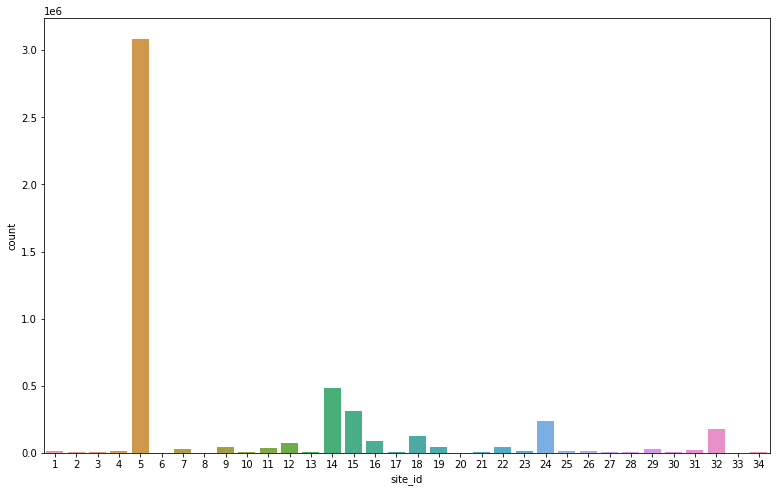

In [ ]:
# Frequency of site where the user books from
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('site_id', data=df_train, ax=ax)
# Only print the top 3 sites to show the main idea
df_train['site_id'].value_counts(normalize=True)[0:3]

Expedia has 34 different websites from which people can book their holiday homes (such as expedia.com, expedia.co.uk, expedia.co.jp etc). The majority (62%) booked from the site with id 5 (probably expedia.com since this is the most general one). The rest of the sites appears much less (second country entails just below 10% of the visitors).

In [ ]:
print("Summary of available origin to destination distances")
print(df_train['orig_destination_distance'].describe().round(2))

Summary of available origin to destination distances
count    3350565.00
mean        1301.23
std         2023.95
min            0.01
25%          139.80
50%          386.60
75%         1500.67
max        11666.64
Name: orig_destination_distance, dtype: float64


There are over 3 million observations for origin to destination distances (meaning that for only 1% of the observations this value is known). The average distance to a holiday destination is 1301.23 miles, the minimal distance is 0.01 miles and the maximum distance is 11666.64 miles (the units of measurement are not known whithin this project, however we assume it is in miles given the maximum distance that is close to halve the circumference of the earth in miles, for kilometers the max distance would have been higher since when I am looking to hotels in Melbourne right now I would have a distance of 16.000 km)

In [ ]:
print("First observation: ", df_train['date_time'].min())
print("Last observation: ", df_train['date_time'].max())

First observation:  2012-11-01 00:08:29
Last observation:  2013-06-30 23:58:24


Data is collected from the first day of November in 2012 till the last day of June in 2013.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


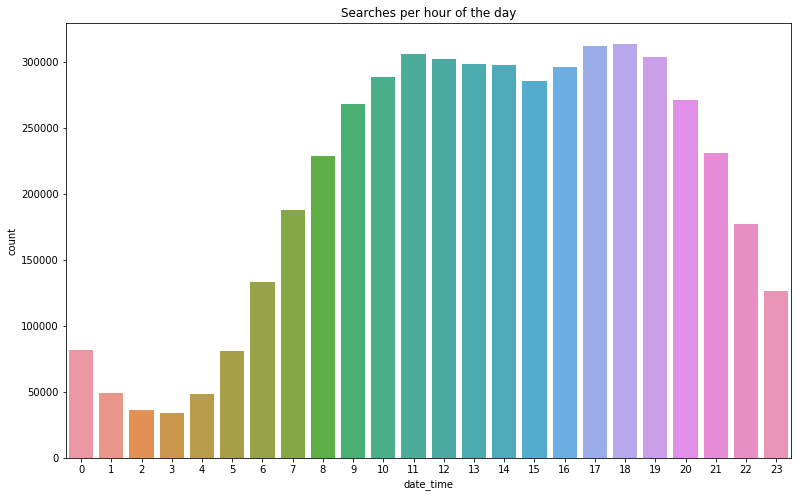

In [ ]:
# Frequency of searches per hour of the day
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
g = sns.countplot(df_train['date_time'].dt.hour, data=df_train, ax=ax)
g.set_title("Searches per hour of the day");

People searched for holiday destinations mostly during daytime especially slightly more in the later mornings(11/12-ish) and at the start of the evening (17/18/19-ish).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


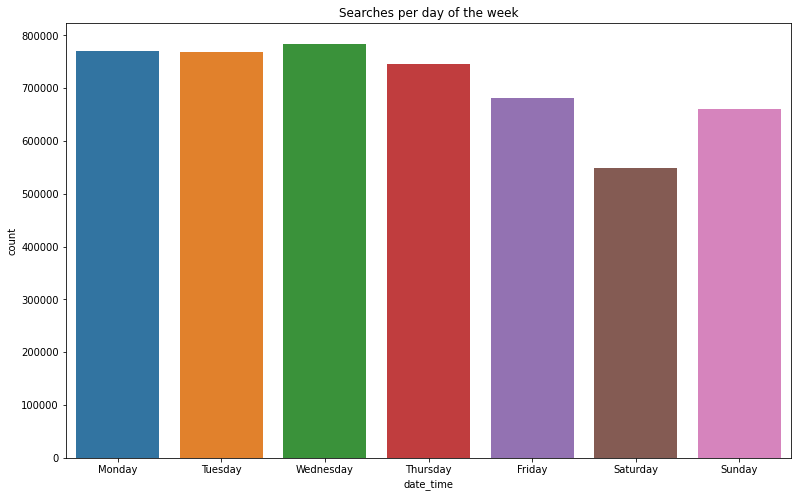

In [ ]:
# Frequency of searches per day of the week
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
g = sns.countplot(df_train['date_time'].dt.weekday, data=df_train, ax=ax)
g.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
g.set_title("Searches per day of the week");

During the weeekend less searches are performed than during the working days, which is in my opinion surprising since I would have thought people use the weekends to plan their holidays.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


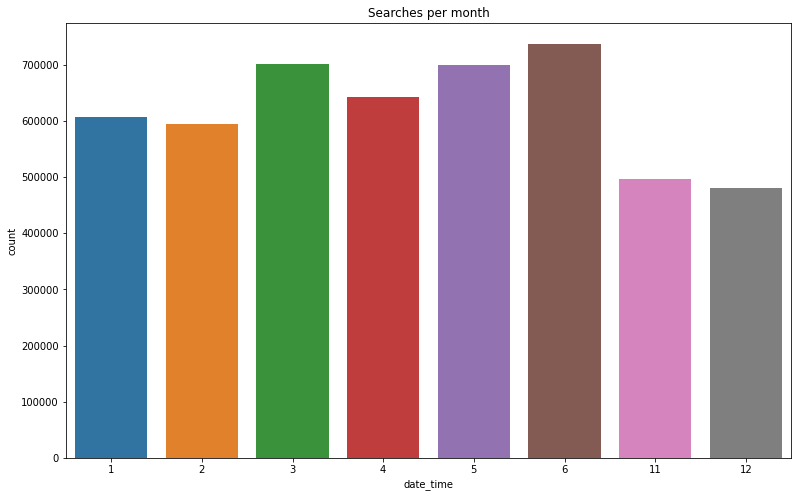

In [ ]:
# Frequency of searches per day of the week
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
g = sns.countplot(df_train['date_time'].dt.month, data=df_train, ax=ax)
#g.set_xticklabels(['January','February','March','April','May','June','July', 'August', 'September', 'October', 'December'])
g.set_title("Searches per month");

In November and December 2012 people searched less to holiday destinations than in the beginning of 2013. March, May and June are months in which most of the holidays are planned. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


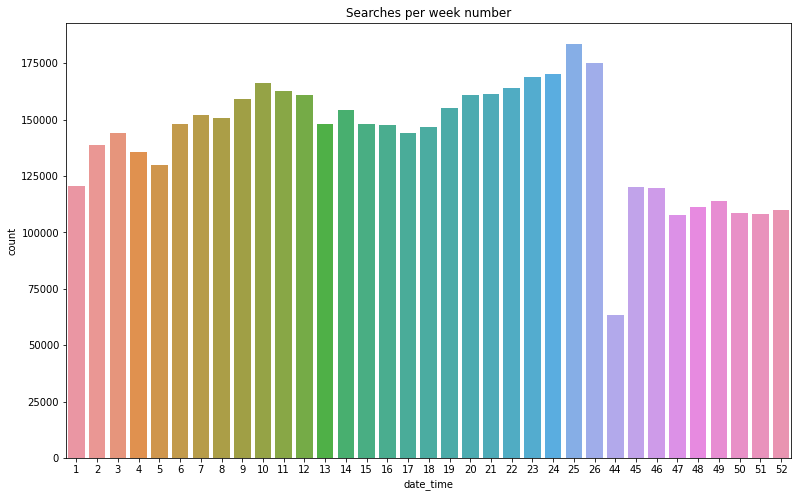

In [ ]:
# Frequency of searches per day of the week
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
g = sns.countplot(df_train['date_time'].dt.week, data=df_train, ax=ax)
g.set_title("Searches per week number");

Does not add much to the information.

In [ ]:
df_train['prop_id'].value_counts().count()

129113

In total there are 129113 unique hotels that people came across in the search results.

In [ ]:
df_train['prop_brand_bool'].value_counts(normalize=True)

1    0.634699
0    0.365301
Name: prop_brand_bool, dtype: float64

63% of the hotels are from a major hotel chain, 37% of the hotels are independent.

In [ ]:
print("Summary of prices of the hotels in USD")
print(df_train['price_usd'].describe().round(2))

Summary of prices of the hotels in USD
count     4958347.00
mean          254.21
std         16001.24
min             0.00
25%            85.00
50%           122.00
75%           184.96
max      19726328.00
Name: price_usd, dtype: float64


Average price for the search results of the customers (note it can be for one day but also multiple days and taxes and fees are excluded from this price) are around 254 USD. Someone managed to get a search result with a price of over 19 million US dollars...

In [ ]:
print("Length of stay")
print(df_train['srch_length_of_stay'].describe().round(2))

Length of stay
count    4958347.00
mean           2.39
std            2.05
min            1.00
25%            1.00
50%            2.00
75%            3.00
max           57.00
Name: srch_length_of_stay, dtype: float64


The lenght of stay on average is 2.39 days with a minimum of 1 and a maximum of 57.

In [ ]:
print("Number of days the booking is in the future")
print(df_train['srch_booking_window'].describe().round(2))


Number of days the booking is in the future
count    4958347.00
mean          37.47
std           51.99
min            0.00
25%            4.00
50%           17.00
75%           48.00
max          492.00
Name: srch_booking_window, dtype: float64


On average searched for a destination 37.47 days ahead with a minimum of zero (same day) and a maximum of 492 days! (well planned)

In [ ]:
print("Rooms")
print(df_train['srch_room_count'].describe().round(2))

Rooms
count    4958347.00
mean           1.11
std            0.42
min            1.00
25%            1.00
50%            1.00
75%            1.00
max            8.00
Name: srch_room_count, dtype: float64


People are mostly searching for just one room, the average is arround 1.11. The maximum amount of rooms that is searched for is 8.

In [ ]:
print("Saterday night included")
df_train['srch_saturday_night_bool'].value_counts(normalize=True)

Saterday night included


1    0.502213
0    0.497787
Name: srch_saturday_night_bool, dtype: float64

In a little more than half of the searches a saterday night is included in the search criteria.

*Only in training dataset*

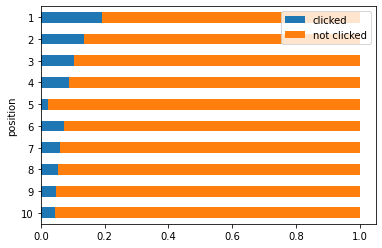

In [ ]:
a = df_train.groupby('position')['click_bool'].value_counts(normalize=True)
a1 = a[0:20].unstack(0)

df_plot_clicks = pd.DataFrame({'clicked': a1.loc[1],
                   'not clicked': a1.loc[0]}, index=a1.columns)
df_plot_clicks.plot.barh(stacked=True).invert_yaxis()

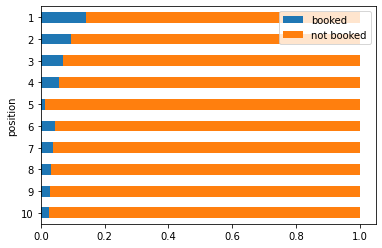

In [ ]:
a = df_train.groupby('position')['booking_bool'].value_counts(normalize=True)
a1 = a[0:20].unstack(0)

df_plot_clicks = pd.DataFrame({'booked': a1.loc[1],
                   'not booked': a1.loc[0]}, index=a1.columns)
df_plot_clicks.plot.barh(stacked=True).invert_yaxis()

From the two plots above it can be seen that the more prominent a hotel is positioned the bigger the chances that it is clicked and booked (note position 1 is the top of the page!). Only the first 10 positions are shown because the clickrates below position 10 are very low and do not provide extra insights.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


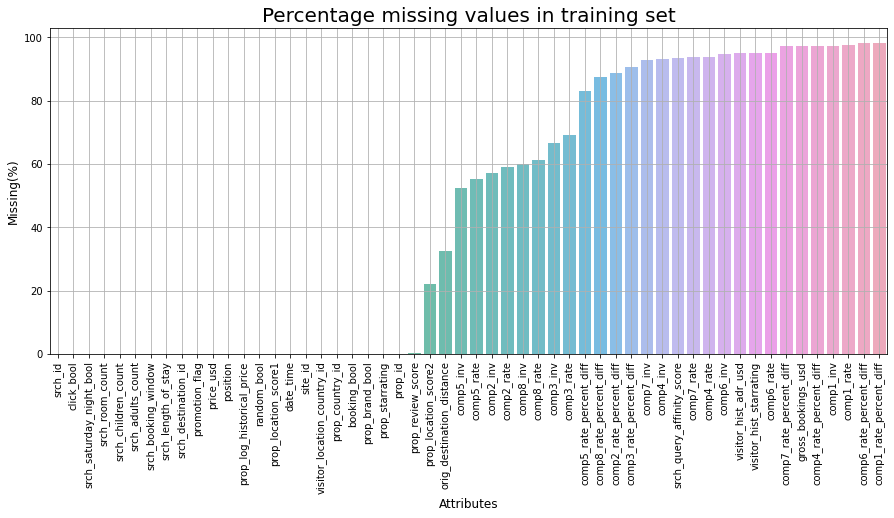

In [ ]:
missing_stats = (df_train.isna().mean().round(4) * 100).sort_values()
plt.figure(figsize=(15, 6))
sns.barplot(missing_stats.index, missing_stats.values, alpha=0.8)
plt.title('Percentage missing values in training set', fontsize=20)
plt.ylabel('Missing(%)', fontsize=12)
plt.xlabel('Attributes', fontsize=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

## Data Preparation
*You’ll certainly need to work on the dataset, to create, modify or add new features. For instance, you might want to compare the different properties that resulted from the search
instead of learning from them one by one. There are certain attributes with a large amount of
missing values, do they still provide useful information? And how will you handle a missing
value if this shows to be the case? Finally, in order to test your approach (since you do not
4
know the answers for the test set) you will need to split up your data to test your approach
yourself before you generate your answers on our test set. Of course, you are also allowed to
use external data sources if you find ones that are useful.*

In [ ]:
# limited dataset for testing purposes
CUT = 500000

def feature_engineering(df, train_or_test, method):

    # use part of the dataset, not the whole when training
    if train_or_test == 'train':
        df = df[:CUT]
    else:
        df.set_index('srch_id',inplace=True)

    ## According to Jun Wang et. al (2nd price in 2013) these 2 were quite important:
    # Differences be-tween  historical  (avg)  star  rating of  user  and  current  starrating
    df['diff_hist_starrating'] = df['visitor_hist_starrating'] - df['prop_starrating']

    # Differences be-tween  historical  (avg)  price  of  user  and  current price
    df['diff_hist_price'] = df['visitor_hist_adr_usd'] - df['price_usd']

    ## According to Owen Zhang (1st price in 2013) these were important:
    # Difference between price most recent hotel and current hotel

    ##############
    # THIS KEEPS CRASHING MY RAM
    ##############

    #df['price_diff_recent'] = df.groupby('srch_id').apply(lambda x: x['price_usd'] - x['price_usd'].shift(1)).fillna(0).reset_index(drop=True)

    ##############

    #priceorder: order ofprice within same srchid,
    df['price_order'] = df.groupby('srch_id')['price_usd'].rank()
    # .reset_index(drop=True)

    df["weekday"] = df["date_time"].dt.weekday
    df["week_of_year"] = df["date_time"].dt.week

    df["hour"] = df["date_time"].dt.hour
    df["minute"] = df["date_time"].dt.minute
    ## total time elapsed - allows model to learn continous trend over time to a degree
    df["time_epoch"] = df["date_time"].astype('int64')//1e9
    df["early_night"] = ((df["hour"]>19) | (df["hour"]<3)) # no added value from feature 
    
    # compute relevance from clicks and bookings
    df['relevance'] = df.apply(lambda row: label_relevance(row), axis=1)

    # Hotel  quality,  where  they  estimated  theprobability of each hotel being 
    # booked/clicked by for example:(number oftime property is booked)/(number of 
    # times property appeared indata).

    df_properties = df.groupby(['prop_id']).size().reset_index(name='observations')
    df_properties_book = df.groupby(['prop_id', 'booking_bool']).size().reset_index(name='bookings')
    df_properties_book = df_properties_book[(df_properties_book['booking_bool']>0)]
    df_book_prob = pd.merge(df_properties, df_properties_book, on='prop_id')
    df_properties_click = df.groupby(['prop_id', 'click_bool']).size().reset_index(name='clicks')
    df_properties_click = df_properties_click[(df_properties_click['click_bool']>0)]
    df_book_prob = pd.merge(df_book_prob, df_properties_click, on='prop_id')
    df_book_prob.pop('booking_bool')
    df_book_prob.pop('click_bool')
    df_book_prob['book_prob'] = df_book_prob['bookings'] / df_book_prob['observations']
    df_book_prob['click_prob'] = df_book_prob['clicks'] / df_book_prob['observations']
    df_book_prob.pop('observations')
    df_book_prob.pop('bookings')
    df_book_prob.pop('clicks')

    dict_book_prob = dict(zip(df_book_prob['prop_id'], df_book_prob['book_prob']))
    dict_click_prob = dict(zip(df_book_prob['prop_id'], df_book_prob['click_prob']))

    del df_book_prob
    del df_properties_book
    del df_properties

    ##### Not tested:
    # save
    with open('dict_book_prob.pkl','wb') as f:
        pickle.dump(dict_book_prob,f)
    # save
    with open('dict_click_prob.pkl','wb') as f:
        pickle.dump(dict_click_prob,f)
    #####

    df['book_prob'] = df['prop_id'].map(dict_book_prob)#.fillna(0)
    df['click_prob'] = df['prop_id'].map(dict_click_prob)#.fillna(0)

    # set dates to ordinals (otherwise you cannot train)
    df['date_time'] = df['date_time'].apply(lambda x: x.toordinal())

    if method=='rf':
        # fill comparisons with zero (saying no diffferance between two when the difference is unknown)
        df['comp5_inv'] = df['comp5_inv'].fillna(0)
        df['comp5_rate'] = df['comp5_rate'].fillna(0)
        df['comp5_rate_percent_diff'] = df['comp5_rate_percent_diff'].fillna(0)
        df['comp3_inv'] = df['comp3_inv'].fillna(0)
        df['comp3_rate'] = df['comp3_rate'].fillna(0)
        df['comp3_rate_percent_diff'] = df['comp3_rate_percent_diff'].fillna(0)
        df['comp2_inv'] = df['comp2_inv'].fillna(0)
        df['comp2_rate'] = df['comp2_rate'].fillna(0)
        df['comp2_rate_percent_diff'] = df['comp2_rate_percent_diff'].fillna(0)
        df['comp8_inv'] = df['comp8_inv'].fillna(0)
        df['comp8_rate'] = df['comp8_rate'].fillna(0)
        df['comp8_rate_percent_diff'] = df['comp8_rate_percent_diff'].fillna(0)

        # take means to fill missing values
        df['prop_location_score2'] = df['prop_location_score2'].fillna(df['prop_location_score2'].mean())
        df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df['orig_destination_distance'].mean())
        df['srch_query_affinity_score'] = df['srch_query_affinity_score'].fillna(df['srch_query_affinity_score'].mean())
        df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].fillna(df['visitor_hist_adr_usd'].mean())
        df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(df['visitor_hist_starrating'].mean())
        df = df.dropna(axis=1)
        
    return df, dict_book_prob, dict_click_prob

# Only used for training the model
def split_features_and_labels(df):

    saved_srch_ids = df['srch_id']
    features = df.drop(['relevance', 'gross_bookings_usd', 'booking_bool', 'click_bool', 'position', 'srch_id'], axis=1)
    labels = df['relevance']
    
    train_cut = int(CUT * 0.8)

    train_features, train_labels = features[:train_cut], labels[:train_cut]
    validation_ids, validation_features, validation_labels = saved_srch_ids[train_cut:], features[train_cut:], labels[train_cut:]

    return train_features, train_labels, validation_ids, validation_features, validation_labels

gc.collect()
df_train, dict_book_prob, dict_click_prob = feature_engineering(df_train, "train", method='xgb')
train_features, train_labels, validation_ids, validation_features, validation_labels = split_features_and_labels(df_train)
df_test = feature_engineering(df_test, "test", method = 'xgb')
gc.collect()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

## Modeling & Evaluation

*Naturally, once you prepare the dataset, you should be able to build models. Use whatever
technique you want, though the choice might be influenced by how we would like to measure
your predictions at the end (described later in this document). To test how your model is
compared to other, you can upload your answers for the test set on the in class Kaggle website:
https://www.kaggle.com/c/2nd-assignment-dmt-2021/ , see previous instructions for
signing up using a different URL. Note that the score shown there is only for part of the test
set, the score on the rest of the test set will only be disclosed on the final lecture and will form
part of your final grade.*

### Baseline

In [ ]:
# To be able to run everything at once
baseline = False
if baseline:
    baseline = []
    srch_ids = df_test_idx.index.unique()
    for srch_id in srch_ids:
        search = df_test_idx.loc[df_test_idx.index == srch_id]
        sample = search.sample(n=len(search), replace=False, random_state=RANDOM_STATE, axis=0)
    for line in sample.prop_id:
        baseline.append([srch_id,line])

    with open('baseline.csv', 'w+') as f:
    csvWriter = csv.writer(f,delimiter=',')
    csvWriter.writerow(['srch_id','prop_id'])
    csvWriter.writerows(baseline)

# Ensemble models
estimators=[]

### XGBoost

In [ ]:
xgb = XGBRegressor( objective='rank:pairwise') #reg:squarederror or rank:pairwise (similar results, rank:ndcg get weird results)

# ENSEMBLE:
estimators.append(("XGB",xgb))

xgb.fit(train_features, train_labels)

feature_list = list(train_features.columns)

# get importance
importances = list(xgb.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in 
                       zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [ ]:
%matplotlib inline
# Set the style
plt.figure(figsize=(12,12))
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'lightgrey'
x_values = list(range(len(importances)))
plt.barh(list(reversed(feature_list)), list(reversed(importances)))
cutoff = max(importances)/4
boolimp = importances < cutoff
plt.ylabel('Variable'); plt.title('Variable Importances for XGBoost')

In [ ]:
# evaluate model

predictions = xgb.predict(validation_features)

df_scoring = validation_ids.to_frame()
df_scoring['labels'] = validation_labels
df_scoring['predictions'] = predictions
df_scoring.set_index('srch_id',inplace=True)

df
ndcgs = []
srch_ids = df_scoring.index.unique()

for srch_id in srch_ids:
  search = df_scoring.loc[df_scoring.index == srch_id]
  search = search.sort_values(by='labels', axis=0,ascending=False)
  ideal_labels = search['labels']
  search = search.sort_values(by='predictions', axis=0,ascending=False)
  sorted_labels = search['labels']
  #print(ndcg_at_k(sorted_labels,ideal_labels, k=5))
  ndcgs.append(ndcg_at_k(sorted_labels,ideal_labels, k=5))

avg_ndcg = sum(ndcgs)/len(ndcgs)
print()
print(avg_ndcg)

In [ ]:
# save
with open('xgb_test.pkl','wb') as f:
    pickle.dump(xgb,f)

In [ ]:
df_test['book_prob'] = df_test['prop_id'].map(dict_book_prob)
df_test['click_prob'] = df_test['prop_id'].map(dict_click_prob)

predictions = xgb.predict(df_test)
df_test['predictions'] = predictions

# write predictions
xgb_list = []
srch_ids = df_test.index.unique()
for srch_id in srch_ids:
  search = df_test.loc[df_test_mod.index == srch_id]
  search = search.sort_values(by='predictions', axis=0,ascending=False)
  for line in search.prop_id:
    xgb_list.append([srch_id,line])

print(xgb_list)

with open('XGBoost.csv', 'w+') as f:
  csvWriter = csv.writer(f,delimiter=',')
  csvWriter.writerow(['srch_id','prop_id'])
  csvWriter.writerows(xgb_list)

Still To do:
-fit (rgb.fit)
-predict
-calc ncdg


As I understand it XGBoost makes use of the LambdaMART algorithm, and by specifying the parameters like this you can optimise for ndcg:

https://stackoverflow.com/questions/63400523/xgboost-ranking-objectives-pairwise-vs-ndcg-map 

but rank:pairwise seems to result in better outcome: https://github.com/dmlc/xgboost/issues/4177

General Tutorial:
https://www.datacamp.com/community/tutorials/xgboost-in-python

Has internal structure for handling missing values: 
https://github.com/dmlc/xgboost/issues/21

### Random Forest

In [ ]:
# Feature engineer the data for RF: now the NA's have to be (and are) handled manually

# fill comparisons with zero (saying no diffferance between two when the difference is unknown)
df['comp5_inv'] = df['comp5_inv'].fillna(0)
df['comp5_rate'] = df['comp5_rate'].fillna(0)
df['comp5_rate_percent_diff'] = df['comp5_rate_percent_diff'].fillna(0)
df['comp3_inv'] = df['comp3_inv'].fillna(0)
df['comp3_rate'] = df['comp3_rate'].fillna(0)
df['comp3_rate_percent_diff'] = df['comp3_rate_percent_diff'].fillna(0)
df['comp2_inv'] = df['comp2_inv'].fillna(0)
df['comp2_rate'] = df['comp2_rate'].fillna(0)
df['comp2_rate_percent_diff'] = df['comp2_rate_percent_diff'].fillna(0)
df['comp8_inv'] = df['comp8_inv'].fillna(0)
df['comp8_rate'] = df['comp8_rate'].fillna(0)
df['comp8_rate_percent_diff'] = df['comp8_rate_percent_diff'].fillna(0)

# take means to fill missing values
df['prop_location_score2'] = df['prop_location_score2'].fillna(df['prop_location_score2'].mean())
df['orig_destination_distance'] = df['orig_destination_distance'].fillna(df['orig_destination_distance'].mean())
df['srch_query_affinity_score'] = df['srch_query_affinity_score'].fillna(df['srch_query_affinity_score'].mean())
df['visitor_hist_adr_usd'] = df['visitor_hist_adr_usd'].fillna(df['visitor_hist_adr_usd'].mean())
df['visitor_hist_starrating'] = df['visitor_hist_starrating'].fillna(df['visitor_hist_starrating'].mean())
df = df.dropna(axis=1)
#df_train, dict_book_prob, dict_click_prob = feature_engineering(df_train, "train", method='rf')

In [ ]:
# fit the model
rf = RandomForestRegressor(n_estimators = 20, random_state = 42)

# ENSEMBLE:
estimators.append(("RF",rf))

rf.fit(train_features, train_labels)

In [ ]:
# feature importances
feature_list = list(train_features.columns)

importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in 
                       zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'lightgrey'
x_values = list(range(len(importances)))
plt.barh(list(reversed(feature_list)), list(reversed(importances)))
cutoff = max(importances)/4
boolimp = importances < cutoff
for i in range(len(boolimp)):
    if boolimp[i]: 
        print(feature_list[i]) 
plt.ylabel('Variable'); plt.title('Variable Importances for RF')

In [ ]:
# evaluate model

predictions = rf.predict(valid_features)

df_scoring = valid_ids.to_frame()[1:]
df_scoring['labels'] = valid_labels[1:]
df_scoring['predictions'] = predictions[1:]
df_scoring.set_index('srch_id',inplace=True)

ndcgs = []
srch_ids = df_scoring.index.unique()

for srch_id in srch_ids:
  search = df_scoring.loc[df_scoring.index == srch_id]
  search = search.sort_values(by='labels', axis=0,ascending=False)
  ideal_labels = search['labels']
  search = search.sort_values(by='predictions', axis=0,ascending=False)
  sorted_labels = search['labels']
  ndcgs.append(ndcg_at_k(sorted_labels,ideal_labels, k=5))

avg_ndcg = sum(ndcgs)/len(ndcgs)
print("NDCG:", avg_ndcg)

In [ ]:
# save
with open('rf_test.pkl','wb') as f:
    pickle.dump(rf,f)

In [ ]:
predictions = rf.predict(df_test)
df_test['predictions'] = predictions

In [ ]:
# write predictions
rf = []
srch_ids = df_test.index.unique()
for srch_id in srch_ids:
  search = df_test.loc[df_test.index == srch_id]
  search = search.sort_values(by='predictions', axis=0,ascending=False)
  for line in search.prop_id:
    rf.append([srch_id,line])

print(rf)

with open('randomForest.csv', 'w+') as f:
  csvWriter = csv.writer(f,delimiter=',')
  csvWriter.writerow(['srch_id','prop_id'])
  csvWriter.writerows(rf)

### Listwise LTR

In [ ]:
import time
import torch
from torch import nn
from argparse import Namespace
from torch.optim import Adam

In [ ]:
# define loss function

def listwise_loss(scores, labels):
    
    """
    Compute the LambdaRank loss. (assume sigma=1.)
    returns: a tensor of size [N, 1]
    """
    
    # YOUR CODE HERE
    from math import e
    sigma = 1
    diff_ij = scores.view(-1,1) - scores.view(1,-1)
    s_ij = torch.sign(labels.view(-1,1) - labels.view(1,-1))
    lambda_ij = sigma *( 0.5 * (1-s_ij) - 1/(1+e**(sigma*diff_ij)))
    
    #idcg - same value for every dcg
    labels_sort = torch.sort(labels,0, descending = True)[0]
    denom_sort = np.log2(torch.arange(2, len(labels_sort) + 1 + 1))
    idcg = torch.sum((2**labels_sort-1)/denom_sort)
    if idcg == 0.0:
        return None
    
    sort_index = np.argsort(list(scores))[::-1]
    sorted_labels = labels.numpy()[sort_index]
    current_ndcg = dcg_at_k(sorted_labels,0) / dcg_at_k(np.array(labels_sort),0)
    #ndcg
    dcg_denom = np.log2(np.arange(scores.size()[0])+2.) # log2(i+1)
    label_matrix = torch.zeros(scores.size()[0], scores.size()[0], scores.size()[0])
    label_matrix[:, :] = torch.from_numpy(sorted_labels)
    
    #delta ndcg
    vertical_matrix, horizontal_matrix = np.meshgrid(np.arange(scores.size()[0]), np.arange(scores.size()[0]))
    vertical_matrix = list(vertical_matrix.flatten())
    horizontal_matrix = list(horizontal_matrix.flatten())
    label_matrix[vertical_matrix,horizontal_matrix,[vertical_matrix,horizontal_matrix]] = label_matrix[vertical_matrix,horizontal_matrix,[horizontal_matrix,vertical_matrix]]
    dcg_nom = 2**label_matrix-1
    
        
    ndcg_swapped = torch.sum(dcg_nom/dcg_denom, dim=2) / idcg
    delta_ndcg = torch.abs(ndcg_swapped - current_ndcg)
    loss = torch.sum(delta_ndcg * lambda_ij, dim = 1)
    
    return torch.unsqueeze(loss,1)

In [ ]:
class NeuralModule(nn.Module):
    def __init__(self, output_dim):
        """
        Input: output_dim: it is either 1 (regression) or 5 (classification)
        """
        super().__init__()
        self.model = nn.Sequential(
                nn.Linear(63,36),
                nn.ReLU(),
                nn.Linear(36,output_dim)
        )
        
    def forward(self, x):
        """
        Takes in an input feature vector (of size 20) and produces the (regression/classification) output 
        Input: x: a [N, 501] tensor
        Output: a [N, output_dim] tensor
        """
        # YOUR CODE HERE
        return self.model(x)

In [ ]:
# data preparation

cut = 300000
df_train_limited = df_train[:cut]

def label_relevance(row):
  if row.booking_bool == 1:
    return 5
  elif row.click_bool == 1:
    return 1
  else:
    return 0

df_train_limited['relevance'] = df_train_limited.apply(lambda row: label_relevance(row), axis=1)

df_train_limited = df_train_limited.dropna(axis='columns')
df_train_limited['date_time']=df_train_limited['date_time'].apply(lambda x: x.toordinal())

df_train_limited.set_index('srch_id',inplace=True)

normalize(df_train_limited,[ 'prop_location_score1', 'prop_log_historical_price', 
                            'price_usd', 'srch_length_of_stay', 'srch_booking_window','srch_adults_count',
                            'srch_children_count', 'srch_room_count', 'orig_destination_distance',
                            'visitor_hist_adr_usd','visitor_hist_starrating'])

df_train_limited = pd.get_dummies(df_train_limited,columns=['site_id'])

train_cut = int(cut * 0.8)

train_data = df_train_limited[:train_cut]
valid_data = df_train_limited[train_cut:]

In [ ]:
def train_listwise(net, params):
    """
    This function should train the given network using the listwise (LambdaRank) loss
    """
    
    val_metrics_epoch = []
    train_metrics_epoch = []
    # YOUR CODE HERE
    optimizer = Adam(net.parameters(), params.lr)
    loss_func = listwise_loss
    time_list = []
    srch_ids = train_data.index.unique()
    for epoch in range(params.epochs):
        running_loss = 0.0
        start_time = time.perf_counter()
        for phase in {"train","eval"}:
            if phase == "train":
                net.train()
                print(f"epoch {epoch + 1}")
                for srch_id in srch_ids:
                        search = train_data.loc[train_data.index == srch_id]
                        features_i = torch.tensor(search.drop(['relevance', 'booking_bool', 'click_bool',
                                                               'prop_id', 'prop_country_id', 'srch_destination_id',
                                                               'position','visitor_location_country_id'], axis =1).values).float()
                        labels_i = torch.tensor(search['relevance'].values)
                        optimizer.zero_grad()
                        output = net(features_i)
                        #output = torch.squeeze(output) # the output from net(features_i) is tensor([[]]) - there is an extra dimension
                        # Compute loss between output and y

                        lambda_ = loss_func(output, labels_i)
                        #the case when the loss is None - in this case we do not compute the gradients
                        if lambda_ is None:
                            continue
                        # Compute gradients

                        #loss.backward()
                        
                        torch.autograd.backward(output, lambda_)

                        # Update weights
                        optimizer.step()
                end_time = time.perf_counter()
                time_list.append(end_time-start_time)
            else:
              pass
                # net.eval()
                # train_eval = evaluate_model(net, "train", print_results=False)
                # val_eval = evaluate_model(net, "validation", print_results=False)

                # aggr_train = {}
                # aggr_val = {}
                # for metric in params.metrics:
                #     aggr_train[metric] = train_eval[metric]
                #     aggr_val[metric] = val_eval[metric]

                # val_metrics_epoch.append(aggr_train)
                # train_metrics_epoch.append(aggr_val)
                
    #perf_dict['listwise_time'] = time_list

    # return {
    #     "metrics_val": val_metrics_epoch,
    #     "metrics_train": train_metrics_epoch
    # }

    return net

In [ ]:
listwise_params_test = Namespace(epochs=1, lr=1e-3, batch_size=1, metrics={"ndcg"})
listwise_net = NeuralModule(1)
trained_model = train_listwise(listwise_net, listwise_params_test)

In [ ]:
def standardize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean) / data_std

    return data

def normalize(data):
    data = (data-data.min())/(data.max()-data.min())

    return data


valid_data_normalized = normalize(valid_data)        

In [ ]:
# evaluate predicitons

ndcgs = []
srch_ids = valid_data.index.unique() # remove 1: when splitting fixed
trained_model.eval

for srch_id in srch_ids:
    search = valid_data.loc[valid_data.index == srch_id].copy()
    predictions = trained_model(torch.tensor(search.drop(['relevance', 'booking_bool', 'click_bool','position',
                                                       'prop_id', 'prop_country_id', 'srch_destination_id',
                                                        'visitor_location_country_id'], axis =1).values).float())
    search['predictions'] = list(predictions)
    search = search.sort_values(by='relevance', axis=0,ascending=False)
    ideal_labels = search['relevance']
    search = search.sort_values(by='predictions', axis=0,ascending=False)
    sorted_labels = search['relevance']
    #print(ndcg_at_k(sorted_labels,ideal_labels, k=5))
    ndcgs.append(ndcg_at_k(sorted_labels,ideal_labels, k=5))

avg_ndcg = sum(ndcgs)/len(ndcgs)
print()
print(avg_ndcg)

# Ensemble



In [ ]:
ensemble = VotingClassifier(estimators)
ec = ensemble.fit(train_features, train_labels)
predictions = ec.predict(validation_features)

In [ ]:
# evaluate model

df_scoring = valid_ids.to_frame()[1:]
df_scoring['labels'] = valid_labels[1:]
df_scoring['predictions'] = predictions[1:]
df_scoring.set_index('srch_id',inplace=True)

ndcgs = []
srch_ids = df_scoring.index.unique()

for srch_id in srch_ids:
  search = df_scoring.loc[df_scoring.index == srch_id]
  search = search.sort_values(by='labels', axis=0,ascending=False)
  ideal_labels = search['labels']
  search = search.sort_values(by='predictions', axis=0,ascending=False)
  sorted_labels = search['labels']
  ndcgs.append(ndcg_at_k(sorted_labels,ideal_labels, k=5))

avg_ndcg = sum(ndcgs)/len(ndcgs)
print("NDCG:", avg_ndcg)

ZOOM CALL FRIDAY 07/05

Baseline: randomized

Ensemble majority vote system algorithm:
*   Random Forest
*   XGBoost (Gradient Boosting performs well when you have unbalanced data https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained#:~:text=Like%20random%20forests%2C%20gradient%20boosting,The%20two%20main%20differences%20are%3A&text=Combining%20results%3A%20random%20forests%20combine,combines%20results%20along%20the%20way. )
*   nr 3: (3 for majority vote): Simple NN? / Support Vector Machine / Naive Bayes => earlier kaggle competitions

DATA:
*   Lots of NA's (and they mean different stuff: missing data & e.g. 0 stars)

TODO
* Bussiness understanding: Look at earlier competitions
* Looking at preparing the data for models
* Implementing RF
* Understanding NA values: what to do
* Balasz: RF
* Roel: Bussiness understanding + XGBoost later

